# 2018 LendingClub Loan Data: Months-in-Loan Prediction

In [1]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
sns.set()
pd.set_option('display.max_columns', 150)

In [2]:
class LoanRegressor:
    
    def __init__(self, model_name, param, features):
        self.model_name = model_name
        self.model = GridSearchCV(estimator=RandomForestRegressor(criterion='mse', random_state=42), 
                                  param_grid=param, cv=3, n_jobs=-1, verbose=2)
        self.features = features
        self.feature_imp = self.metrics = None
        self.y_predict = self.y_error = None
    
    def evaluate(self, X_train, y_train, X_test, y_test):
        self.y_train = y_train
        start_time = time.time()
        self.model.fit(X_train, y_train)
        stop_time = time.time()
        self.y_predict = np.round(self.model.predict(X_test), 1)
        self.y_error = self.y_predict - y_test
        mse = mean_squared_error(y_test, self.y_predict)
        metrics_dict = {'model_name': self.model_name,
                        'mse': mse,             # mean squared error
                        'rmse': np.sqrt(mse),   # relative mean squared error
                        'mae': mean_absolute_error(y_test, self.y_predict),     # mean absolute error
                        'R-squared': self.model.score(X_train, y_train),
                        'training_time': stop_time - start_time}  
        self.metrics = pd.DataFrame(metrics_dict, index=[0])
        # sort feature importance in descending order
        self.feature_imp = pd.Series(self.model.best_estimator_.feature_importances_, 
                                index=self.features).sort_values(ascending=False)
    
    def plot_feature_importance(self, figsize=(6, 6)):
        fig, ax = plt.subplots(figsize=figsize)
        
        # create a bar plot of feature importance
        sns.barplot(x=self.feature_imp, y=self.feature_imp.index)

        # add labels to graph
        plt.xlabel('Score', size=13)
        plt.ylabel('Features', size=13)
        plt.title('Feature Importance', size=15)
        plt.show()

In [3]:
# load train & test dataset
X_train = pd.read_pickle('out/X_train.pkl')
X_test = pd.read_pickle('out/X_test.pkl')
X = pd.concat([X_train, X_test])

y_train = X_train['months_in_loan']
y_test = X_test['months_in_loan']
X_train = X_train.drop(['months_in_loan'], axis=1)
X_test = X_test.drop(['months_in_loan'], axis=1)

In [4]:
param = {'bootstrap': [True], 'n_estimators': [50]}

## Base Model

In [5]:
base_model = LoanRegressor('base_model', param, list(X_train.columns))
base_model.evaluate(X_train, y_train, X_test, y_test)
base_model.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.0min finished


,model_name,mse,rmse,mae,R-squared,training_time
0,base_model,15.385022,3.922374,3.237386,0.871849,240.0619


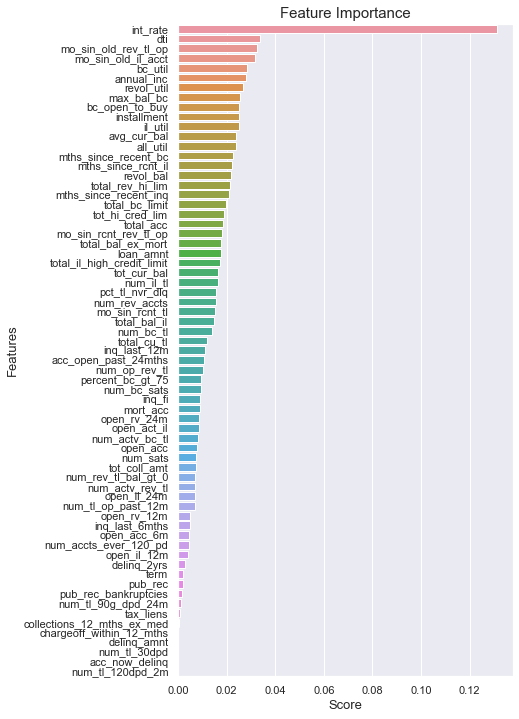

In [6]:
base_model.plot_feature_importance((6,12))

## Model with Reduced Features

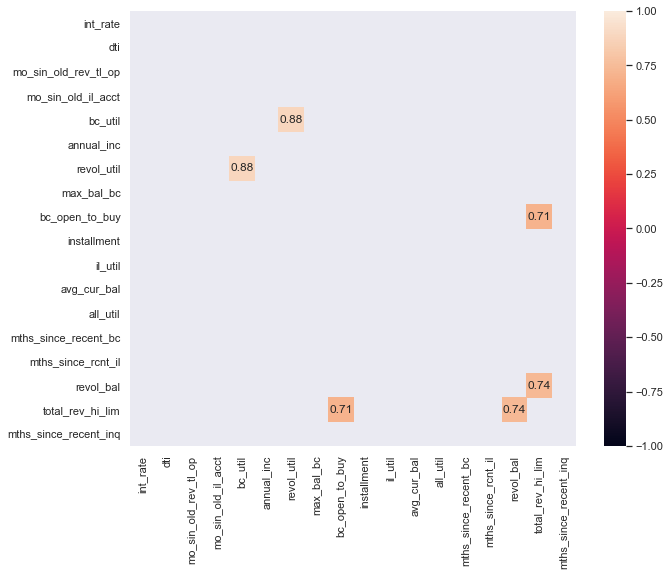

In [7]:
# select features with important score > 0.02
features_gt_2 = list(base_model.feature_imp[base_model.feature_imp > 0.02].index)

# create heat map of correlation
fig, ax = plt.subplots(figsize=(10, 8))
corr = X[features_gt_2].corr()
strong_corr = corr >= 0.7
exclude_one = corr != 1
corr = corr[strong_corr & exclude_one]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
plt.show()

In [8]:
# remove strong correlated features
features_m1 = list(set(features_gt_2) - set(['bc_util', 'total_rev_hi_lim']))

model1 = LoanRegressor('feature_reduction', param, features_m1)
model1.evaluate(X_train[features_m1], y_train, X_test[features_m1], y_test)
model1.metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   41.7s finished


,model_name,mse,rmse,mae,R-squared,training_time
0,feature_reduction,15.510222,3.938302,3.246415,0.871484,87.549685


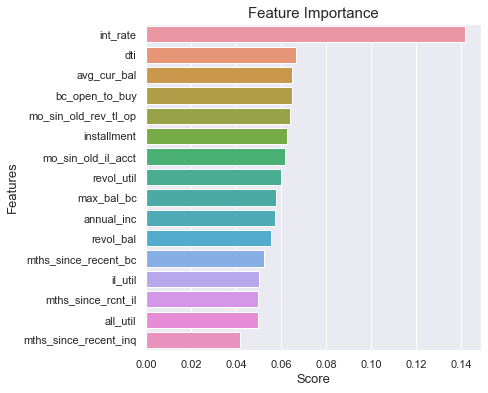

In [9]:
model1.plot_feature_importance()

## Model with Grid Search and Reduced Features

In [10]:
param_grid = {'bootstrap': [True],
              'max_depth': [3, 5, 10],
              'max_features': ['sqrt'],
              'min_samples_leaf': [5, 6, 7],
              'min_samples_split': [6, 8, 10],
              'n_estimators': [20, 50, 100]}

model2 = LoanRegressor('grid_search', param_grid, features_m1)
model2.evaluate(X_train[features_m1], y_train, X_test[features_m1], y_test)
model2.metrics

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:  5.4min finished


,model_name,mse,rmse,mae,R-squared,training_time
0,grid_search,16.500856,4.062125,3.373749,0.109093,338.585933


In [11]:
model2.model.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 7,
 'min_samples_split': 6,
 'n_estimators': 100}

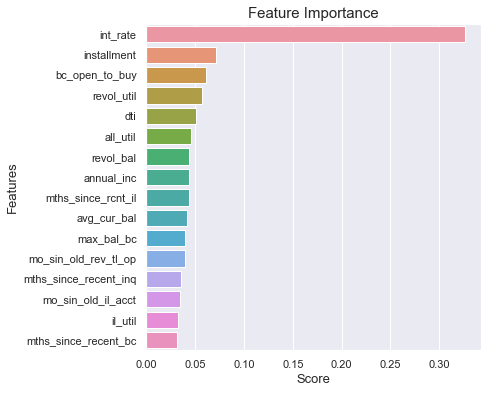

In [12]:
model2.plot_feature_importance()

## Model Comparision

In [13]:
metrics_all = pd.concat([base_model.metrics, model1.metrics, model2.metrics])
metrics_all

,model_name,mse,rmse,mae,R-squared,training_time
0,base_model,15.385022,3.922374,3.237386,0.871849,240.061900
0,feature_reduction,15.510222,3.938302,3.246415,0.871484,87.549685
0,grid_search,16.500856,4.062125,3.373749,0.109093,338.585933


## Making Predictions

In [14]:
best_model = model1

predictions = pd.read_pickle('out/lc_predictions.pkl')          # load predictions from rf classifier

predictions['actual_mil'] = y_test                   # actual months-in-loan
predictions['predict_mil'] = best_model.y_predict    # predicted months-in-loan
predictions['predict_error'] = best_model.y_error
predictions['actual_label'] = predictions['actual_label'].apply(lambda x: 'fully-paid' if x == 0 else 'default')
predictions['predict_label'] = predictions['predict_label'].apply(lambda x: 'fully-paid' if x == 0 else 'default')
predictions.head()

,loan_amnt,installment,actual_label,predict_label,prob_fully_paid,prob_default,actual_mil,predict_mil,predict_error
45974,7000.0,210.78,fully-paid,fully-paid,0.88,0.12,7.0,9.9,2.9
17213,1600.0,48.74,fully-paid,fully-paid,0.98,0.02,15.9,9.3,-6.6
60558,20000.0,693.51,fully-paid,fully-paid,0.69,0.31,9.0,4.9,-4.1
66856,7000.0,240.85,fully-paid,fully-paid,0.77,0.23,3.0,5.3,2.3
16513,20000.0,684.33,fully-paid,fully-paid,0.84,0.16,14.9,7.0,-7.9


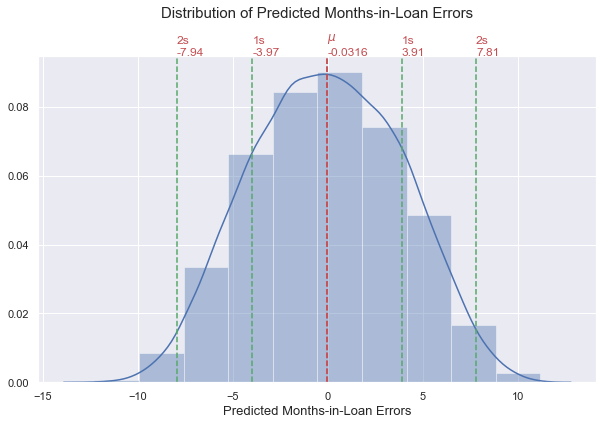

In [15]:
# plot prediction error
mu = round(predictions['predict_error'].mean(), 4)
std = predictions['predict_error'].std(ddof=1)
label_offset = 0.002
label_h = 0.095
mu_label='$\mu$\n'

fig, ax = plt.subplots(figsize=(10, 6))

_ = sns.distplot(predictions['predict_error'], bins=10)
ax.axvline(mu, linestyle='--', color='r')

# mean
plt.text(mu-label_offset, label_h, mu_label + str(mu), color='r')    
ax.axvline(mu, linestyle='--', color='r')

# plot vertical line for n-standard deviation
n_stds = []
for x in range(1,3):
    n_stds.append([round((mu - std)*x, 2), round((mu + std)*x, 2)])
    for s in n_stds[x-1]:
        ax.axvline(s, linestyle='--', color='g')
        plt.text(s, label_h, str(x) +'s\n' + str(s), color='r')  

plt.xlabel('Predicted Months-in-Loan Errors', size=13)
plt.title('Distribution of Predicted Months-in-Loan Errors\n\n', size=15)
plt.show()

In [16]:
# compute 68/95 pct confident interval for predicted months-in-loan
def compute_cf(x, n_std):
    lower = round(x + n_std[0], 2)
    if lower < 0: lower = 0
    upper = round(x + n_std[1], 2)
    return (lower, upper)

# 68% confident interval
predictions['predict_mil_68cf'] = predictions['predict_mil'].apply(lambda x: compute_cf(x, n_stds[0]))
# 95% confident interval
predictions['predict_mil_95cf'] = predictions['predict_mil'].apply(lambda x: compute_cf(x, n_stds[1]))
predictions.head()

,loan_amnt,installment,actual_label,predict_label,prob_fully_paid,prob_default,actual_mil,predict_mil,predict_error,predict_mil_68cf,predict_mil_95cf
45974,7000.0,210.78,fully-paid,fully-paid,0.88,0.12,7.0,9.9,2.9,"(5.93, 13.81)","(1.96, 17.71)"
17213,1600.0,48.74,fully-paid,fully-paid,0.98,0.02,15.9,9.3,-6.6,"(5.33, 13.21)","(1.36, 17.11)"
60558,20000.0,693.51,fully-paid,fully-paid,0.69,0.31,9.0,4.9,-4.1,"(0.93, 8.81)","(0, 12.71)"
66856,7000.0,240.85,fully-paid,fully-paid,0.77,0.23,3.0,5.3,2.3,"(1.33, 9.21)","(0, 13.11)"
16513,20000.0,684.33,fully-paid,fully-paid,0.84,0.16,14.9,7.0,-7.9,"(3.03, 10.91)","(0, 14.81)"


## Save Model and Predictions

In [17]:
# save classifier
import pickle

pickle.dump(model1, open('out/lc_random_forest_regressor.sav', 'wb'))  # save model             
predictions.to_excel('out/final_predictions.xlsx')                     # save predictions 